In [31]:
import regex as re

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [61]:
with open("./geoffrey.txt", "r", encoding="utf-8") as file:
    content = file.read()
    
# sample = content
# sample[:1000]

sample = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

sample

'Machine learning is the study of computer algorithms that improve automatically through experience. It is seen as a subset of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so. Machine learning algorithms are used in a wide variety of applications, such as email filtering and computer vision, where it is difficult or infeasible to develop conventional algorithms to perform the needed tasks.'

---
    training data should look like:
    
    <center>       ->    <context>
    [0, ..., 1, 0] ->    [0, ..., 1, 0]
    [0, ..., 1, 0] ->    [0, ..., 0, 1]
    [0, ..., 1, 0] ->    [1, ..., 0, 0]
    ...            ->    ...
    
    where the center word (input) have a number of <context words>
    based on the size of the window hence:
        if window_size = 2; two context words from both sides (left & right).
    
    objective:
        based on the given input <center word> try to predict the output <context word>
        and when we reach to a good performance we hope that the neural network will
        try to extract hiddin features, which are going to be the meanings of input words
        in a numerical representation.
        
    steps:
        1. split input text into chunks (tokens)
        2. assign a token_id per token
        3. encode thoes tokens based on their ids (one-hot encoding)
        4. building the training data as intended above
        5. 
    
    NOTE: this is going to be the basic solution and from here i'll try to improve.
    
    


In [62]:
def tokenize(text):
    # simple tokenizer
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def encode(token_id, vocab_size):
    vector = [0] * vocab_size  # which is going to be the input vector size
    vector[token_id] = 1
    return np.array(vector)  # for training (later)

In [63]:
tokens = tokenize(sample)
tokens[:8]

['machine', 'learning', 'is', 'the', 'study', 'of', 'computer', 'algorithms']

In [64]:
token_to_id = {t: i for i, t in enumerate(set(tokens))}
id_to_token = {i: t for i, t in enumerate(set(tokens))}

In [65]:
vocab_size = len(set(tokens))
vocab_size

60

In [66]:
def combine(*iterables):
    # to combine two iterables
    # into single iterable
    for iterable in iterables:
        yield from iterable

def build_train(tokens, token_to_id, vocab_size, window_size=2, verbose=False):
    center_vectors = []
    context_vectors = []
    for i, center in enumerate(tokens):
        # context words iterable on the right side
        r_ctx = range(i+1, min(i+window_size+1, len(tokens)))
        # context words iterable on the left side
        l_ctx = range(max(0, i-window_size), i)
        # combined context iterables from both sides
        c_ctx = combine(l_ctx, r_ctx)
    
        # get numerical representation (one-hot encoding)
        # for both: 1. center word 2. context word    
        cnt_w_id = token_to_id[center]  
        cnt_w_vector = encode(cnt_w_id, vocab_size)  # 1. center word
        for w_id in c_ctx:
            if verbose:
                # <center word>  ->  <ctx word>
                print(f"{center} -> {tokens[w_id]}")
                
            ctx_w_id = token_to_id[tokens[w_id]]
            ctx_w_vector = encode(ctx_w_id, vocab_size)  # 2. context word
            
            center_vectors.append(cnt_w_vector)
            context_vectors.append(ctx_w_vector)
    # store them as numpy.array for training        
    return np.array(center_vectors), np.array(context_vectors)

In [84]:
cnt, ctx = build_train(tokens, token_to_id, vocab_size)
print("center words shape: ", cnt.shape)
print("context words shape: ", ctx.shape)

center words shape:  (330, 60)
context words shape:  (330, 60)


    center words are duplicated:
    where the same center word has more than context words
    the size depends on the `window_size`
    
    center word (1) -> context word (1)
                    -> context word (2)
                    -> ...
                    -> context word (N)
    ...
    center word (M) -> context word (1)
                    -> context word (2)
                    -> ...
                    -> context word (N)


---

    Forward pass:
    -------------
    A1   = X @ W1
    A2   = A1 @ W2
    Z    = softmax(A2)
    Loss = cross_entropy(Z, y)
    
    
    How changing W2 impacted the loss?
    ----------------------------------
    >> dLoss(Z, y)/dW2 = dLoss/dZ * dZ/dA2 * dA2/dW2 
    >> dLoss(Z, y)/dW2 = (z - y)           * A1
    shape convention:
    - (z - y): (#samples, vocab_size)
    - A1:      (#samples, embedding_size)
    
    shape of target matrix to update (W2): (embedding_size, vocab_size)
    
    ==> A1.T @ (z-y)
    
    
    How changing W1 impacted the loss?
    ----------------------------------
    >> dLoss(Z, t)/dW1 = dLoss/dZ * dZ/dA2 * dA2/dA1 * dA1/dW1
    >> dLoss(Z, t)/dW1 = (z - y)           * W2      * X
    
    shape convention:
    - (z - y): (#samples, vocab_size)
    - W2:      (embedding_size, vocab_size)
    - X:       (#samples, vocab_size) 
    
    shape of target matrix to update (W1): (vocab_size, embedding_size)
    
    ==> x.T @ ( (z-y) @ W2.T )
    

In [100]:
np.random.seed(42)

class Model:
    def __init__(self, X, y, vocab_size, embedding_size):
        self.X = X
        self.y = y
        self.vocab_size = vocab_size
        self.w1 = np.random.rand(vocab_size, embedding_size)
        self.w2 = np.random.rand(embedding_size, vocab_size)
    
    def forward(self):
        self.a1 = self.X @ self.w1
        self.a2 = self.a1 @ self.w2
        self.z = self._softmax(self.a2)
        return self.z
    
    def backward(self, alpha):
        self.forward()
        # derivatives
        dl = self.z - self.y
        dw2 = self.a1.T @ dl
        dw1 = self.X.T @ (dl @ self.w2.T)
        # shape validation
        assert(dw2.shape == self.w2.shape)
        assert(dw1.shape == self.w1.shape)
        # update weights
        self.w1 = self.w1 - (alpha * dw1)
        self.w2 = self.w2 - (alpha * dw2)
        # compute loss
        return self._cross_entropy(self.y, self.z)
    
    @staticmethod    
    def _softmax(a):
        a = a - np.max(a)
        exp_ = np.exp(a)
        return exp_ / exp_.sum()
    
    @staticmethod
    def _cross_entropy(actual, predicted, epsilon=1e-10):
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        return - np.sum(actual * np.log(predicted))

In [101]:
model = Model(cnt, ctx, vocab_size, 5)

In [102]:
model.backward(alpha=0.05)

3319.330148428598

100%|██████████| 100/100 [00:00<00:00, 1277.89it/s]


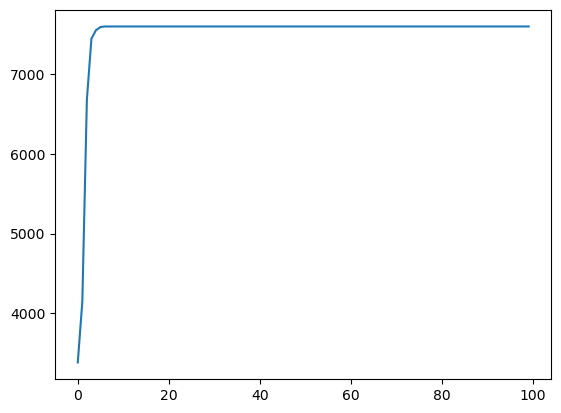

loss: 7598.53080688035
CPU times: user 685 ms, sys: 215 ms, total: 900 ms
Wall time: 151 ms


In [103]:
%%time
history = []
steps = []
for step in tqdm(range(100)):
    history.append(model.backward(alpha=0.05))
    steps.append(step)
    
plt.plot(steps, history)
plt.show()

print("loss:", history[-1])